In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
import os

# **Loading Data**

In [ ]:
def load_images(data_dir, img_size=(128, 128)):
    images = []
    for file_name in os.listdir(data_dir):
        file_path = os.path.join(data_dir, file_name)
        img = cv2.imread(file_path)
        if img is not None:
            img = cv2.resize(img, img_size)
            images.append(img)
    return np.array(images)

In [ ]:
data_path = "/kaggle/input/the-oxfordiiit-pet-dataset/images"
images = load_images(data_path)
print(f"Loaded {len(images)} images")

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


Loaded 7384 images.


# **Normalization and Splitting**

In [ ]:
images = images / 255.0

train_images, test_images = train_test_split(images, test_size=0.2, random_state=42)
print(f"Training set size: {len(train_images)}, Testing set size: {len(test_images)}")

Training set size: 5907, Testing set size: 1477


# **Add Noise**

In [ ]:
def add_noise(images, noise_type="gaussian", noise_level=0.1):
    if noise_type == "gaussian":
        noise = np.random.normal(loc=0.0, scale=noise_level, size=images.shape)
    elif noise_type == "salt_and_pepper":
        noise = np.random.binomial(1, noise_level, images.shape)
    else:
        raise ValueError("Unsupported noise type.")
    noisy_images = images + noise
    return np.clip(noisy_images, 0., 1.)

In [ ]:
noisy_train_images = add_noise(train_images, noise_type="gaussian", noise_level=0.2)
noisy_test_images = add_noise(test_images, noise_type="gaussian", noise_level=0.2)

# **Plotting Before and After Noising**

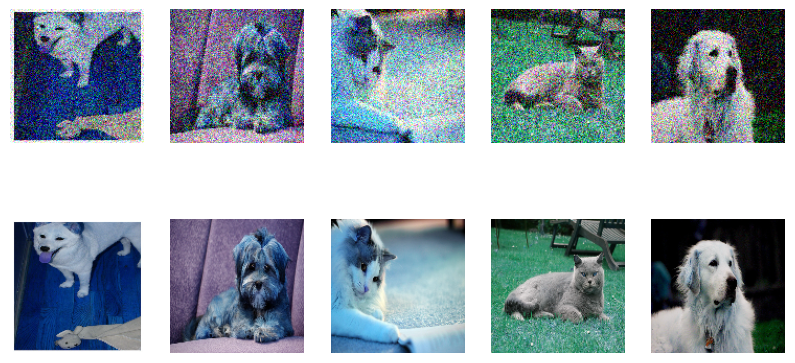

In [ ]:
plt.figure(figsize=(10, 5))
for i in range(5):
    plt.subplot(2, 5, i + 1)
    plt.imshow(noisy_train_images[i])
    plt.axis("off")
    plt.subplot(2, 5, i + 6)
    plt.imshow(train_images[i])
    plt.axis("off")
plt.show()

# **Biulding Convolutional Denoising Autoencode**r

In [ ]:
def build_cdae(input_shape):
    encoder = models.Sequential([
        layers.InputLayer(input_shape=input_shape),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2))
    ])
    decoder = models.Sequential([
        layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same'),
        layers.UpSampling2D((2, 2)),
        layers.Conv2DTranspose(32, (3, 3), activation='relu', padding='same'),
        layers.UpSampling2D((2, 2)),
        layers.Conv2DTranspose(3, (3, 3), activation='sigmoid', padding='same')
    ])
    autoencoder = models.Sequential([encoder, decoder])
    return autoencoder

In [ ]:
input_shape = train_images[0].shape
cdae = build_cdae(input_shape)
cdae.compile(optimizer='adam', loss='mse')
cdae.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ ?                      │        19,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,392 (75.75 KB)

 Trainable params: 19,392 (75.75 KB)

 Non-trainable params: 0 (0.00 B)

# **Fitting the Model**

In [ ]:
history = cdae.fit(
    noisy_train_images, train_images,
    validation_data=(noisy_test_images, test_images),
    epochs=20,
    batch_size=32
)

Epoch 1/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 188s 1s/step - loss: 0.0243 - val_loss: 0.0074
Epoch 2/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 184s 994ms/step - loss: 0.0072 - val_loss: 0.0063
Epoch 3/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 185s 998ms/step - loss: 0.0063 - val_loss: 0.0060
Epoch 4/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 218s 1s/step - loss: 0.0060 - val_loss: 0.0057
Epoch 5/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 185s 999ms/step - loss: 0.0057 - val_loss: 0.0055
Epoch 6/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 185s 1s/step - loss: 0.0055 - val_loss: 0.0054
Epoch 7/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 194s 1s/step - loss: 0.0054 - val_loss: 0.0053
Epoch 8/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 186s 1s/step - loss: 0.0052 - val_loss: 0.0051
Epoch 9/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 185s 1s/step - loss: 0.0052 - val_loss: 0.0051
Epoch 10/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 199s 1s/step - loss: 0.0052 - val_loss: 0.0050
Epoch 11/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 185s 1000ms/step - loss: 0.0051 - val_loss: 0.0050
Epoch 12/20
185/185 ━━━━━━━━

# **Ploting History**

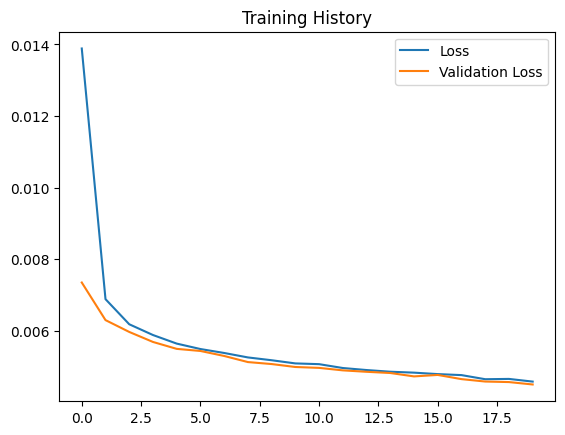

In [ ]:
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training History')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


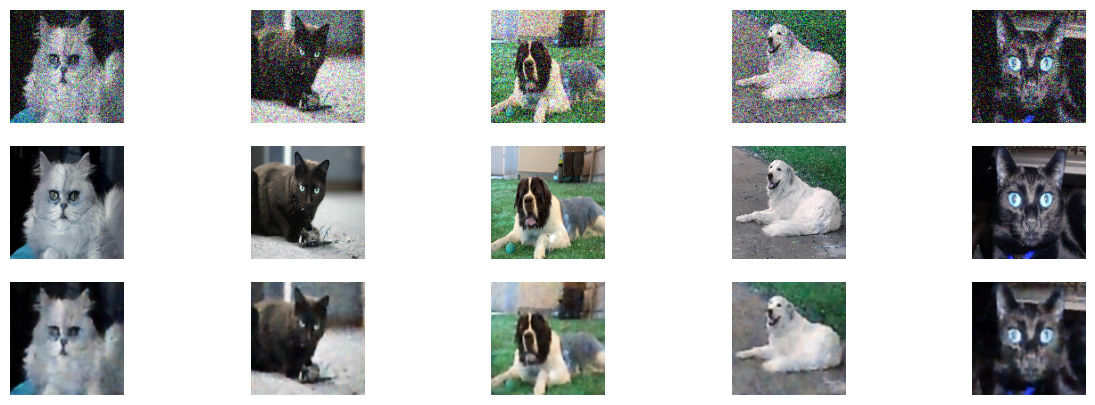

In [ ]:
n = 5

plt.figure(figsize=(15, 5))
for i in range(n):
    plt.subplot(3, n, i + 1)
    plt.imshow(noisy_test_images[i])
    plt.axis("off")
    if i == 0:
        plt.ylabel("Noisy")

    plt.subplot(3, n, i + 1 + n)
    plt.imshow(test_images[i])
    plt.axis("off")
    if i == 0:
        plt.ylabel("Ground Truth")

    denoised_image = cdae.predict(np.expand_dims(noisy_test_images[i], axis=0))[0]
    plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(denoised_image)
    plt.axis("off")
    if i == 0:
        plt.ylabel("Denoised")
plt.show()